In [1]:
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import pandas as pd
import os

import torch
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
# import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import json
from glob import glob

from datetime import datetime

import DeepFashion_Toolbox as TB
import DeepFashion_EmbeddingPipeline as Pipeline

In [2]:
img_path_train = './DF2_images/DeepFashion2/train/image/'
img_path_val = './DF2_images/DeepFashion2/validation/image/'
# img_path_test = './DF2_images/DeepFashion2/test/image/' # Test images contain no bounding boxxes

"In category_id,
- 1 represents short sleeve top,
- 2 represents long sleeve top,
- 3 represents short sleeve outwear,
- 4 represents long sleeve outwear,
- 5 represents vest,
- 6 represents sling,
- 7 represents shorts,
- 8 represents trousers,
- 9 represents skirt,
- 10 represents short sleeve dress,
- 11 represents long sleeve dress,
- 12 represents vest dress and
- 13 represents sling dress."

-- DeepFashion2 gitbub readme

In [3]:
# get annotations and image files
train_annotations_file = glob('./DF2_images/DeepFashion2/train/annos/*.json')
train_images_file = glob('./DF2_images/DeepFashion2/train/image/*.jpg')

val_annotations_file = glob('./DF2_images/DeepFashion2/validation/annos/*.json')
val_images_file = glob('./DF2_images/DeepFashion2/validation/image/*.jpg')

# test_annotations_file = glob('./DF2_images/DeepFashion2/test/annos/*.json')
# test_images_file = glob('./DF2_images/DeepFashion2/test/image/*.jpg')

# annot indices
train_annotations_indices = TB.get_idxs(train_annotations_file)
val_annotations_indices = TB.get_idxs(val_annotations_file)
# test_annotations_indices = get_idxs(test_annotations_file)

# images indices
train_images_indices = TB.get_idxs(train_images_file, annotations=False)
val_images_indices = TB.get_idxs(val_images_file, annotations=False)
# test_images_indices = get_idxs(test_images_file, annotations=False)


# get matchin indices between images and annotations
train_common_indices = set(train_images_indices).intersection(set(train_annotations_indices))
val_common_indices = set(val_images_indices).intersection(set(val_annotations_indices))
# test_common_indices = set(test_images_indices).intersection(set(test_annotations_indices))

# check: number of unmatching files
train_extra_files = [file for file in train_annotations_indices if file not in train_common_indices]
val_extra_files = [file for file in val_annotations_indices if file not in val_common_indices]
# test_extra_files = [file for file in test_annotations_indices if file not in test_common_indices]

# annotations_indices = [string[-11:-5] for string in annotations_file]
# images_indices = [string[-10:-4] for string in images_file]

In [4]:
# display(len(train_extra_files))
# display(len(val_extra_files))
# display(len(test_extra_files))

In [5]:
# annotations_file = [item for item in annotations_file if(item != './DF2_images/DeepFashion2/annos/000000.json')]
# display(annotations_file)# == './DF2_images/DeepFashion2/annos/000000.json')
# display(annotations_file)

In [4]:
# construct dataframes
df_train = TB.df_constructor(train_annotations_file, img_path_train)#.sample(100)
df_val = TB.df_constructor(val_annotations_file, img_path_val)#.sample(100)
# df_test = df_constructor(test_annotations_file, img_path_test)

In [5]:
bad_train_images = TB.look_for_smaller_images(df_train, 128, 256)
bad_val_images  = TB.look_for_smaller_images(df_val, 128, 256)

In [6]:
# df_train[df_train.index.isin(bad_train_images)]
df_train = df_train.drop(bad_train_images).reset_index(drop=True)
df_val = df_val.drop(bad_val_images).reset_index(drop=True)

In [9]:
# flatten segmentation coordinates list by one dimension
# df_train['segmentation'] = df_train['segmentation'].apply(lambda x: x[0])
# df_val['segmentation'] = df_val['segmentation'].apply(lambda x: x[0])

==========================================================================================

In [7]:

df_train = df_train.drop(df_train[df_train['img_id'] == '101338'].index)
# df_train.shape

# type(df_train.loc[0, 'img_id'])

In [ ]:
df_train.to_csv('DeepFashion2Train_Analysis.csv')

==========================================================================================

In [11]:
display(df_train.head())
display(df_val.head())

display(df_train.shape)
display(df_val.shape)

# display(df_test.head())
# display(df_train.loc[0, 'segmentation'])
# display(df_train.loc[1, 'segmentation'])
# display(df_train.loc[2, 'segmentation'])

img_id      bounding_boxxes category_id  \
0  116936  [86, 510, 410, 835]           7   
1  116936    [0, 25, 638, 852]           2   
2  074592   [50, 41, 443, 380]           1   
3  074592  [67, 306, 439, 690]           9   
4  013856  [251, 80, 612, 610]          12   

                                        segmentation  \
0  [[404, 598, 237, 610, 125, 527, 108, 615, 91, ...   
1  [[466, 43, 402, 79, 338, 102, 302, 76, 295, 34...   
2  [[333, 59, 300, 80, 245, 86, 194, 80, 174, 54,...   
3  [[149, 326, 252, 321, 352, 315, 397, 455, 436,...   
4  [[352, 82, 365, 112, 398, 113, 439, 101, 462, ...   

                                           img_path  
0  ./DF2_images/DeepFashion2/train/image/116936.jpg  
1  ./DF2_images/DeepFashion2/train/image/116936.jpg  
2  ./DF2_images/DeepFashion2/train/image/074592.jpg  
3  ./DF2_images/DeepFashion2/train/image/074592.jpg  
4  ./DF2_images/DeepFashion2/train/image/013856.jpg

img_id       bounding_boxxes category_id  \
0  013856  [107, 239, 531, 955]          10   
1  025437  [183, 100, 478, 489]           7   
2  025437    [190, 0, 464, 139]           1   
3  015081  [305, 378, 515, 642]           8   
4  015081   [245, 51, 540, 430]           1   

                                        segmentation  \
0  [[117.90363482670946, 361.87320371935715, 107....   
1  [[216.1803886654836, 106.65176656170267, 232.8...   
2  [[204.3820086626426, 0.0, 203.08552955441243, ...   
3  [[315.8539395245276, 395.7920461699007, 316.46...   
4  [[358.34003658778676, 54.55059296720165, 354.7...   

                                            img_path  
0  ./DF2_images/DeepFashion2/validation/image/013...  
1  ./DF2_images/DeepFashion2/validation/image/025...  
2  ./DF2_images/DeepFashion2/validation/image/025...  
3  ./DF2_images/DeepFashion2/validation/image/015...  
4  ./DF2_images/DeepFashion2/validation/image/015...

(307429, 5)

(51575, 5)

### Dataset

In [12]:
# transforms

# train
bbox_transform = transforms.Compose([
                                        transforms.RandomResizedCrop(size=(256, 256)),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomRotation(degrees=(0, 180)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406),
                                                             (0.229, 0.224, 0.225)) ])

# val and test
eval_bbox_transform = transforms.Compose([
                                        transforms.Resize((256, 256)), 
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406),
                                                             (0.229, 0.224, 0.225)),
])

In [13]:
class dataset_(torch.utils.data.Dataset):
    def __init__(self, data, transform_bbox):
        """
        Args:
            data: images dataframes
            transforms: preprocess transforms
        """
        self.data = data
        self.transform_bbox = transform_bbox
    
    def __getitem__(self, index): 

        curr  = self.data.iloc[index]
        img =  Image.open(curr['img_path'])
        bbox = curr['bounding_boxxes']
        sliced_img = TB.bbox_croper(img, bbox, 'DeepFashion2') # list of images
        
        image_tensor = self.transform_bbox(sliced_img) #self.transform_img(sliced_img)
        label = curr['category_id'] 
        
        return image_tensor, label

    def __len__(self):
        return len(self.data) 
    
    

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

### Training loop

In [15]:
import torch.optim as optim

In [16]:
criterion = nn.MSELoss() 
# criterion = nn.BCELoss()
num_epochs = 260
device = 'cuda:1'

# ResNet50
encoder = Pipeline.Encoder50(encoded_space_dim=64,fc2_input_dim=512).to(device)
decoder = Pipeline.Decoder50().to(device)

# ResNet18
# encoder = Pipeline.Encoder(encoded_space_dim=64,fc2_input_dim=128).to(device)
# decoder = Pipeline.Decoder().to(device)

autoencoder_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(autoencoder_params, lr=1e-4) # updates simultaneously both NN parameters

In [17]:
val_ds = dataset_(df_val, eval_image_transform, eval_bbox_transform)
val_dlr = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

NameError: name 'eval_image_transform' is not defined

In [18]:
start_time = datetime.now()

In [ ]:
best_score = 100
model_path = './Saved_Models/DF2_Embedding/Emb8.4_Model{}.pt' #'./DF2_images/DeepFashion/Saved_Models/DF2_Embedding' DeepFashion/Saved_Models/DF2_Embedding

train_losses = []
val_losses = []

# Train & CV loop
for epoch in range(num_epochs):
    
    print('Epoch: ', epoch)
    runtime = datetime.now()
    
    train_ds = dataset_(df_train.sample(50000), bbox_transform)
    train_dlr = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
    
    encoder, decoder, loss_list = Pipeline.train(device, encoder, decoder, train_dlr, criterion, optimizer)
    train_losses.append(np.mean(loss_list) )
    
    # validation every 5 epochs
    if (epoch % 5) == 0:
        print('==='*20)
        val_encoder, val_loss_list, val_loss = Pipeline.val(device, encoder, decoder, val_dlr, criterion, optimizer)
        if val_loss < best_score: 
            torch.save(val_encoder.state_dict(), model_path.format(start_time) )
            best_score = val_loss
            print(epoch)
        val_losses.append(val_loss)
        print('==='*20)
        
#     import pdb; pdb.set_trace()
    print('Mean loss: ', np.mean(loss_list).round(5))
    print(datetime.now() - runtime)
    
    print('==='*40)
    print('==='*40)

Epoch:  0


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iteration 3124 (100.0%): Loss = 0.02555825
Val iteration 3223 (100.0%): Loss = 0.02902372
0
Mean loss:  0.02556
0:20:55.003046
Epoch:  1
Iteration 3124 (100.0%): Loss = 0.01812158
Mean loss:  0.01812
0:13:34.997276
Epoch:  2
Iteration 3124 (100.0%): Loss = 0.01626840
Mean loss:  0.01627
0:13:37.898393
Epoch:  3
Iteration 3124 (100.0%): Loss = 0.01463808
Mean loss:  0.01464
0:13:32.554990
Epoch:  4
Iteration 3124 (100.0%): Loss = 0.01372541
Mean loss:  0.01373
0:13:32.016976
Epoch:  5
Iteration 3124 (100.0%): Loss = 0.01313559
Val iteration 3223 (100.0%): Loss = 0.02014936
5
Mean loss:  0.01314
0:21:25.012840
Epoch:  6
Iteration 3124 (100.0%): Loss = 0.01253844
Mean loss:  0.01254
0:13:29.319475
Epoch:  7
Iteration 3124 (100.0%): Loss = 0.01202918
Mean loss:  0.01203
0:13:23.777162
Epoch:  8
Iteration 3124 (100.0%): Loss = 0.01168227
Mean loss:  0.01168
0:13:18.571969
Epoch:  9
Iteration 3124 (100.0%): Loss = 0.01149658
Mean loss:  0.0115
0:13:32.130962
Epoch:  10
Iteration 3124 (100.0%

In [1]:
start_time

NameError: name 'start_time' is not defined

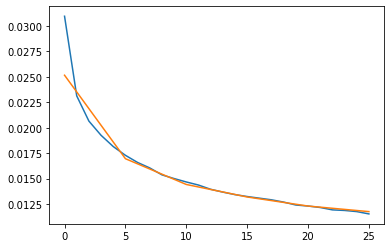

In [31]:
epochs_array = np.arange(num_epochs)

plt.plot(train_losses)
plt.plot([0, 5, 10, 15, 20, 25], val_losses)

plt.show()


# ================================

### Implement embedding

In [21]:
# display(train_losses)
# display(val_losses)

In [22]:
print(start_time)
encoder = Pipeline.Encoder50(encoded_space_dim=64,fc2_input_dim=128)
encoder.load_state_dict(torch.load( model_path.format(start_time) ) )

2021-12-16 10:09:24.800938


<All keys matched successfully>

In [35]:
df_embedding = pd.concat([df_train, df_val]).reset_index(drop=True)
embedding_ds = dataset_(df_embedding, eval_image_transform, eval_bbox_transform)
embedding_dlr = torch.utils.data.DataLoader(embedding_ds, batch_size=16, shuffle=True)

In [36]:
# fct performs embedding
def embedder(device, encoder, loader, embedding_shape):
    
    encoder = encoder.to(device)
    
    # Just a place holder for our 0th image embedding.
    embeddings = torch.randn(embedding_shape)
#     embedding.double()
    
    # Again we do not compute loss here so. No gradients.
    with torch.no_grad():
        for batch_idx, (bbox_tensor, target, label) in enumerate(loader, 0):  # TODO: add a tqdm here
            bbox_tensor = bbox_tensor.to(device)
            target = target.to(device)
            
#             train_img, target_images = to_device(sample_batched['image'], device), to_device(sample_batched['features'], device)
            
#             img = Variable(train_img.view(len(sample_batched['image']), 3, RESCALE_SIZE, RESCALE_SIZE))
            
            # Get encoder outputs and move outputs to cpu
            enc_output = encoder(bbox_tensor).detach().cpu()
#             import pdb; pdb.set_trace()
            # Keep adding these outputs to embeddings.
            embeddings = torch.cat((embeddings, enc_output), 0) #embeddings.double(),
    
    # Return the embeddings
    return embeddings

In [37]:
# Save the feature representations.
embedding_shape = (16, 128) # (1, 256, 8, 8)  # 256/8 = 32

# performs embedding
embedding_start_time = datetime.now()
embedding_space = embedder(device, encoder, embedding_dlr, embedding_shape)
embedding_time = datetime.now() - embedding_start_time
print(embedding_time)

# Convert embedding to numpy and save them for complete dataset
numpy_embedding = embedding_space.cpu().detach().numpy()
num_images = numpy_embedding.shape[0]
flattened_embedding = numpy_embedding.reshape((num_images, -1))
np.save("data_embeddingResNetBG.npy", flattened_embedding)

0:48:20.316293


### Get similar images

In [52]:
from sklearn.neighbors import NearestNeighbors

In [72]:
def get_similar_images(ref_image, num_images, embedding, encoder):
    
#     image_tensor = ref_image
    image_tensor = ref_image.unsqueeze(0)
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        # encode ref_image
        image_embedding = encoder(image_tensor).cpu().detach().numpy()
        
        # flatten tensor
        flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))
        
#         import pdb; pdb.set_trace()
        knn = NearestNeighbors(n_neighbors = num_images, metric = "cosine")
        knn.fit(embedding)

        indices = knn.kneighbors(flattened_embedding, return_distance=False)
        indices_list = indices.tolist()

    return indices_list

In [78]:
def evaluation_metrics(index_list_):
    '''creates dictionary 
        img_id : category_id '''
    
    categories_dict = {id_ : df_embedding.loc[id_, 'category_id'] for  id_ in index_list_[0] if id_ in df_embedding.index}
        
    return categories_dict

### Performs test

In [83]:
def get_accuracy(list_):
    acc = 0.0
    for i in range(len(list_)):
        acc += (np.array(list(evaluation_metrics(index_list).values()) ) == list_[i]).sum()

    return acc

In [84]:
# load embedding
emb = np.load("./data_embeddingResNet.npy")

In [96]:
samples_list = list(df_val.sample(100, random_state=1)['img_id'])

In [97]:
# test recommendation system
# sample_image_id = '008735'

overall_acc = []
for sample_image_id in samples_list:
    
    sample_image = Image.open("./DF2_images/DeepFashion2/validation/image/"+str(sample_image_id)+".jpg") # input test img <-- TODO: get a few images out of val set as test set

#     sample_image = Image.open("./DF2_images/DeepFashion2/validation/image/008735.jpg") # input test img <-- TODO: get a few images out of val set as test set

    np_image = np.asarray(sample_image)
    np_image = np.resize(np_image, (3, 256, 256))

#     np_image.shape

    # np_image = np_image.transpose((2, 0, 1)) # TODO: check this out

    tensor_image = torch.from_numpy(np_image).type(torch.float) 
    tensor_image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(tensor_image)

    index_list = get_similar_images(tensor_image, 10, emb, encoder)

    # np_image = np_image.transpose((2, 0, 1)) # TODO: check this out

    tensor_image = torch.from_numpy(np_image).type(torch.float) 
    tensor_image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(tensor_image)

    index_list = get_similar_images(tensor_image, 10, emb, encoder)

    # accuracy = ( np.array(list(evaluation_metrics(index_list).values()) ) == df_embedding.loc[df_embedding.img_id == sample_image_id, 'category_id']).sum() / 10

#     display(list(df_embedding.loc[df_embedding.img_id == sample_image_id, 'category_id']) )
#     display(np.array(list(evaluation_metrics(index_list).values()) ) )

    # list_ = list(df_embedding.loc[df_embedding.img_id == sample_image_id, 'category_id'])

    acc = get_accuracy(list(df_embedding.loc[df_embedding.img_id == sample_image_id, 'category_id']) )
    
    overall_acc.append(acc)
    
overall_acc = np.array(overall_acc)

# display(overall_acc.mean())
display(overall_acc.sum() / 10)

51.7

#### Example

Ref image:


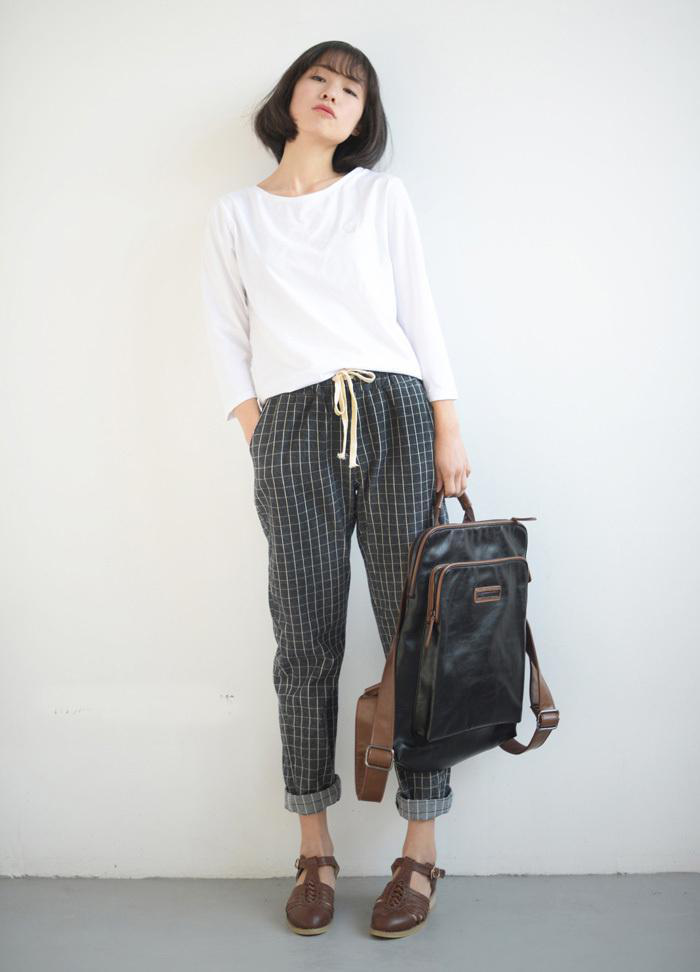

Suggestion images


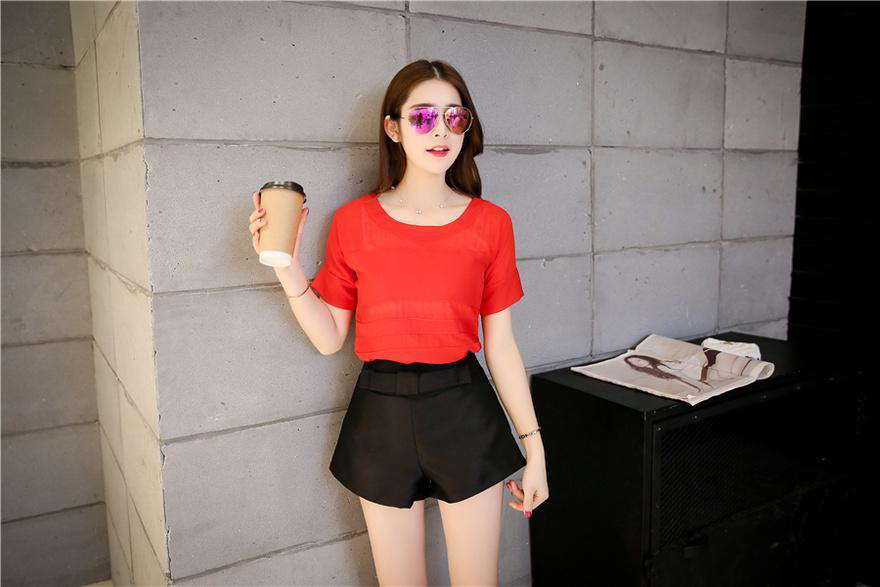

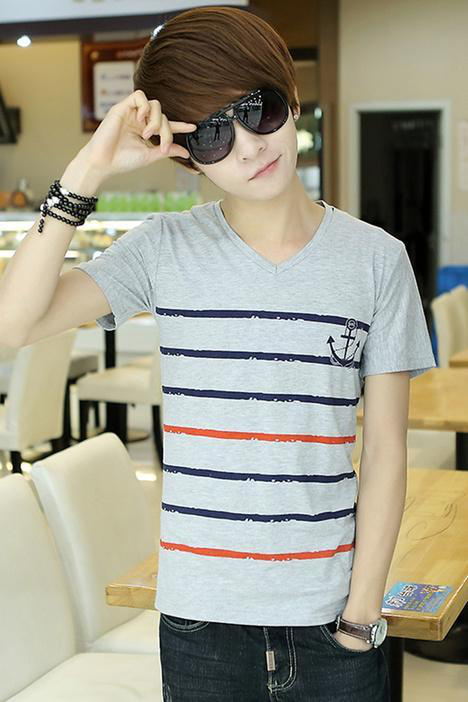

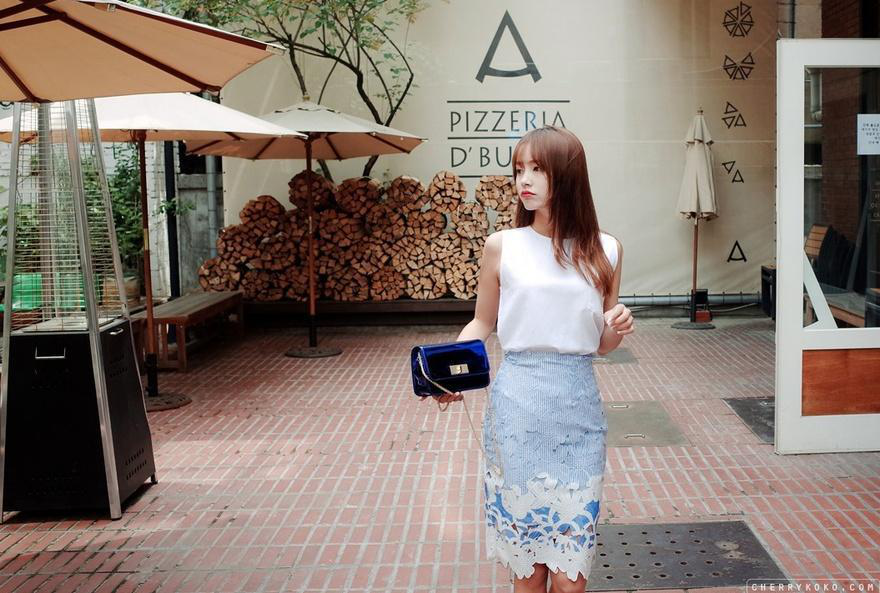

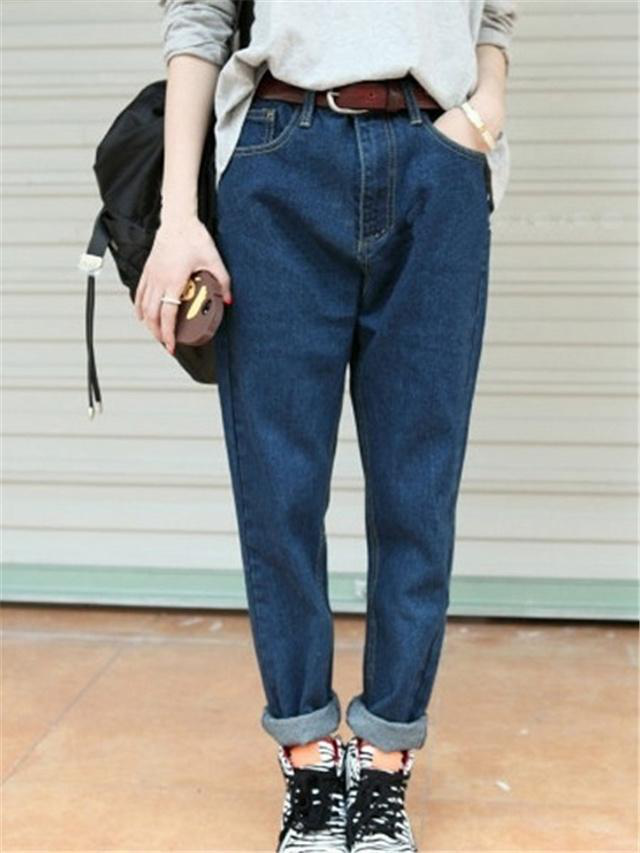

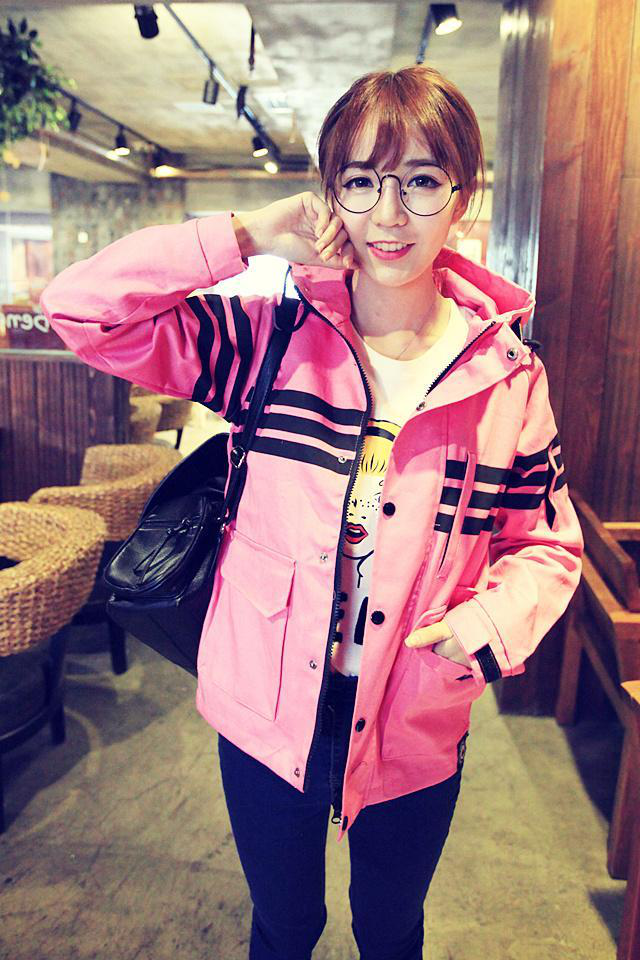

In [111]:
random_image = Image.open(df_val.sample(1)['img_path'].values[0]) 
# df_val.sample(1)['img_path'].values[0]

np_image = np.asarray(random_image)
np_image = np.resize(np_image, (3, 256, 256)) # TODO: check this


np_image.shape

# np_image = np_image.transpose((2, 0, 1)) # TODO: check this out

tensor_image = torch.from_numpy(np_image).type(torch.float) 
tensor_image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(tensor_image)

index_list = get_similar_images(tensor_image, 10, emb, encoder)


print('Ref image:')
display(random_image)

print('Suggestion images')
for id_ in index_list[0][0:5]:
    
    img_path = df_embedding.loc[id_, 'img_path']
#     if(len(id_) < 6):
#         try:
    img_ = Image.open(img_path)

#     img_ = Image.open("./DF2_images/DeepFashion2/train/image/"+str(0)+id_+".jpg")
    display(img_)

#### ALL NEW FROM HERE

COMPUTE N INDICES OF SIMILAR IMAGES

SEARCH SIMILAR IMAGES

In [77]:
df_embedding[df_embedding['img_id'] == 225494]

Empty DataFrame
Columns: [img_id, bounding_boxxes, img_path]
Index: []

In [12]:
# load embedding
emb = np.load("./data_embedding.npy")

In [20]:
image = Image.open("/data/imgRel/tie4.jpg") #input img

a = np.asarray(image)
a = transform.resize(a, (128, 128))
a = a.transpose((2, 0, 1)) 

image_t = torch.from_numpy(a)
image_t = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(image_t)

index_list = compute_similar_images(image_t, 5, emb)

In [48]:
index_list

[[27786, 12037, 17284, 14335, 22552]]

# End